In [1]:
import numpy as np
from scipy import integrate

from matplotlib import pyplot as pl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation

In this Notebook we explore the Lorenz system of differential equations:

$$
\begin{aligned}
\dot{x} & = \sigma(y-x) \\
\dot{y} & = \rho x - y - xz \\
\dot{z} & = -\beta z + xy
\end{aligned}
$$

This is one of the classic systems in non-linear differential equations. It exhibits a range of different behaviors as the parameters ($\sigma$, $\beta$, $\rho$) are varied.

In [2]:
def lorenz_deriv(x_y_z, t0, sigma=10.0, beta=8./3, rho=28.0):
    """Compute the time-derivative of a Lorenz system."""
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

# Choose random starting points, uniformly distributed from -15 to 15
N = 2
max_time = 100

np.random.seed(1)
x0 = -15 + 30 * np.random.random((N, 3))

# Solve for the trajectories
t = np.linspace(0, max_time, int(250*max_time))
x_t = np.asarray([integrate.odeint(lorenz_deriv, x0i, t)
                      for x0i in x0])

In [3]:
x_t.shape

(2, 25000, 3)

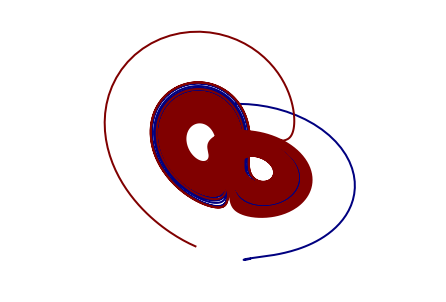

In [6]:
fig = pl.figure()
ax = fig.add_axes([0, 0, 1, 1], projection='3d')
ax.axis('off')

# prepare the axes limits
ax.set_xlim((-25, 25))
ax.set_ylim((-35, 35))
ax.set_zlim((5, 55))
    
# choose a different color for each trajectory
colors = pl.cm.jet(np.linspace(0, 1, N))

for i in range(N):
    x, y, z = x_t[i,:,:].T
    lines = ax.plot(x, y, z, '-', c=colors[i])
    pl.setp(lines, linewidth=2)

ax.view_init(30, 0)
pl.show()

In [7]:
#compute derivative 
x_dot = np.zeros((x_t.shape[1],x_t.shape[2]))

for i in range(x_t.shape[1]):

    x_dot[i,:] = lorenz_deriv(x_t[1,i,:],0)

In [8]:
#generate polinomial combination 

from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

Theta = poly.fit_transform(x_t[1,:,:])

In [9]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

lasso = Lasso(random_state=0, max_iter=10000)
alphas = np.logspace(-4, -0.5, 30)

tuned_parameters = [{"alpha": alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)
clf.fit(Theta, x_dot)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]

In [10]:
#compute system density

rho = []

for alpha_ in alphas:
    regr = Lasso(alpha=alpha_,max_iter=10000)
    regr.fit(Theta,x_dot)
    tmp_rho = np.count_nonzero(regr.coef_)/30
    rho.append(tmp_rho)

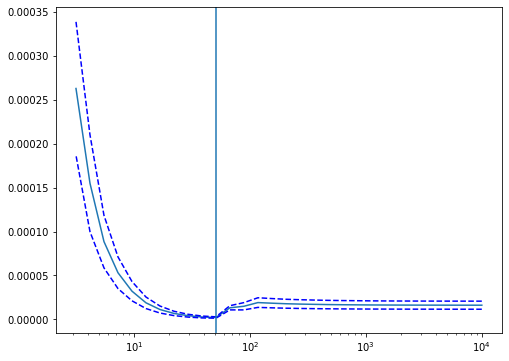

In [16]:
pl.figure().set_size_inches(8, 6)


pl.semilogx(1/alphas, 1 - scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

pl.semilogx(1/alphas, 1 - scores + std_error, "b--")
pl.semilogx(1/alphas, 1 - scores - std_error, "b--")
pl.axvline(x = 1/clf.best_params_['alpha'])


In [17]:
best_Lasso = Lasso(alpha = clf.best_params_['alpha'])

best_Lasso.fit(Theta, x_dot)

/home/riccardo/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8720.676214945603, tolerance: 4855.4581835477475
  model = cd_fast.enet_coordinate_descent(
/home/riccardo/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12452.316782744485, tolerance: 11827.094421613154
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.0196382800192977)

In [18]:
best_Lasso.coef_.shape

(3, 10)

In [20]:
x0_ = x_t[1,0,:]

tmp = poly.fit_transform(x0_.reshape(1,3))
np.dot(tmp,best_Lasso.coef_.T).shape

(1, 3)

In [21]:
#temporal integration of the reconstructed model from data

def compute_sparse_derivative(x,t):
    
    tmp = poly.fit_transform(x.reshape(1,3))
    return np.dot(tmp,best_Lasso.coef_.T).reshape(3)

In [22]:
compute_sparse_derivative(x0_,t).reshape(3)

array([ -46.57639569, -228.07310151,   94.40059245])

In [23]:
t = np.linspace(0, max_time, int(250*max_time))

x_t_sparse = integrate.odeint(compute_sparse_derivative, x0_, t)

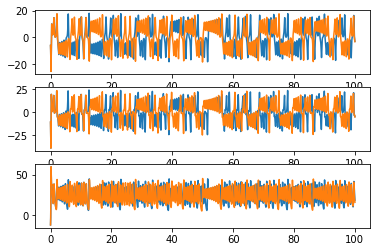

In [24]:
#plot the sparse trajectory vs 

for i in range(3):

    pl.subplot(3,1,i+1)
    pl.plot(t,x_t[1,:,i])
    pl.plot(t,x_t_sparse[:,i])